In [510]:
import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from talib import  BBANDS, ROC, EMA, MACD
from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter
from scipy.stats import johnsonsu, skew, kurtosis
#from datetime import datetime

data_dir = 'data'

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]

# Initialize an empty list to store DataFrames
df_list = []

# Read each JSON file and append the DataFrame to the list
for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    df = pd.read_json(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df_org = pd.concat(df_list, ignore_index=True)


def compute_average_ask_bid(price_data):
    if( price_data['Ask'] is not None and price_data['Bid'] is not None):
        return (price_data['Ask'] + price_data['Bid']) / 2
    else:
        return None

df_org['openPrices'] = [compute_average_ask_bid(OpenPrice) for OpenPrice in df_org["OpenPrice"]];
df_org['highPrices'] = [compute_average_ask_bid(HighPrice) for HighPrice in df_org["HighPrice"]];
df_org['lowPrices'] = [compute_average_ask_bid(LowPrice) for LowPrice in df_org["LowPrice"]];
df_org['closedprices'] = [compute_average_ask_bid(closedprice) for closedprice in df_org["ClosePrice"]];

## Drop rows with None values
df_org.dropna(subset=['closedprices', 'highPrices', 'lowPrices', 'openPrices'], inplace=True)


# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['olhc4'] / df_org['olhc4'].shift(1))
df_org['forward_returns'] = df_org['log_returns'].shift(-1)
df_org['momentum'] = np.log(df_org['closedprices']/df_org['closedprices'].shift(20))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

# Extract unique days
df_org['Date'] = df_org['SnapshotTime'].dt.date
unique_days = df_org['Date'].unique()

df_org.head()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,closedprices,olhc4,log_returns,forward_returns,momentum,Date
0,"{'Ask': 7290.0, 'Bid': 7288.0, 'LastTraded': N...","{'Ask': 7297.0, 'Bid': 7294.0, 'LastTraded': N...",74,"{'Ask': 7288.7, 'Bid': 7286.7, 'LastTraded': N...","{'Ask': 7296.2, 'Bid': 7293.2, 'LastTraded': N...",2024-11-18 08:00:00,2024-11-18T07:00:00,7294.7,7295.5,7287.7,7289.0,7291.725,NaN,-0.000943,NaN,2024-11-18
1,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",53,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",2024-11-18 08:01:00,2024-11-18T07:01:00,7288.0,7288.0,7281.7,7281.7,7284.850,-0.000943,-0.000731,NaN,2024-11-18
2,"{'Ask': 7278.0, 'Bid': 7276.0, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",18,"{'Ask': 7277.7, 'Bid': 7275.7, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",2024-11-18 08:02:00,2024-11-18T07:02:00,7282.2,7282.2,7276.7,7277.0,7279.525,-0.000731,0.000024,NaN,2024-11-18
3,"{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",25,"{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...","{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...",2024-11-18 08:03:00,2024-11-18T07:03:00,7277.2,7282.2,7277.2,7282.2,7279.700,0.000024,0.000072,NaN,2024-11-18
4,"{'Ask': 7279.7, 'Bid': 7277.7, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",22,"{'Ask': 7279.2, 'Bid': 7277.2, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",2024-11-18 08:04:00,2024-11-18T07:04:00,7282.0,7282.0,7278.2,7278.7,7280.225,0.000072,-0.000333,NaN,2024-11-18


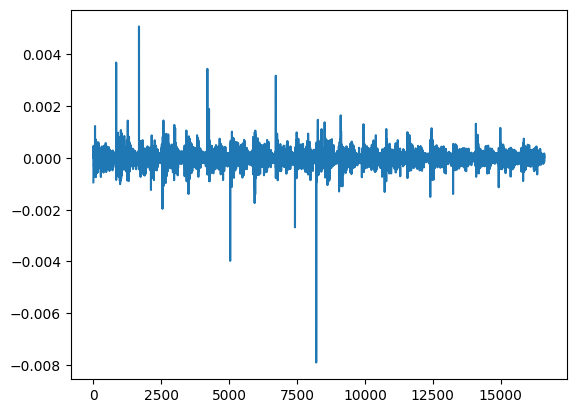

In [511]:


plt.plot(df_org['log_returns'] )
plt.show()

In [512]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16587 entries, 0 to 16605
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ClosePrice        16587 non-null  object        
 1   HighPrice         16587 non-null  object        
 2   LastTradedVolume  16587 non-null  int64         
 3   LowPrice          16587 non-null  object        
 4   OpenPrice         16587 non-null  object        
 5   SnapshotTime      16587 non-null  datetime64[ns]
 6   SnapshotTimeUTC   16587 non-null  object        
 7   openPrices        16587 non-null  float64       
 8   highPrices        16587 non-null  float64       
 9   lowPrices         16587 non-null  float64       
 10  closedprices      16587 non-null  float64       
 11  olhc4             16587 non-null  float64       
 12  log_returns       16586 non-null  float64       
 13  forward_returns   16586 non-null  float64       
 14  momentum          16567 non

In [513]:

up, mid, low = BBANDS(df_org.closedprices, timeperiod=21, nbdevup=1.5, nbdevdn=1.5, matype=0)
roc10= ROC(df_org.closedprices, timeperiod=10 )
roc13= ROC(df_org.closedprices, timeperiod=13 )
roc15= ROC(df_org.closedprices, timeperiod=15 )
roc20= ROC(df_org.closedprices, timeperiod=20 )
#kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)


kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.05) # 0.01


kf2 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.1)

kstmt = 1.618 * roc10 +  1.5*roc13 +  1.382 * roc15+ 1.236*roc20

olhc4_filter, _ = kf.filter(df_org['closedprices'])
olhc4_filter2, _ = kf2.filter(df_org['closedprices'])
#




roc300= ROC(df_org.olhc4, timeperiod=50 )
roc400= ROC(df_org.olhc4, timeperiod=100 )
roc600= ROC(df_org.olhc4, timeperiod=150 )
roc800= ROC(df_org.olhc4, timeperiod=200 )
kstlt = 1.618 * EMA(roc300, 30) +  1.5*EMA(roc400,40) +  1.382 * EMA(roc600,60) + 1.236*EMA(roc800,80)

kstmtup, kstmtmid, kstmtlow = BBANDS(kstmt, timeperiod=40, nbdevup=1.2, nbdevdn=1.2, matype=0)

df_org['roc10'] = roc10
df_org['kstmt'] = kstmt 
df_org['kstmtup'] = kstmtup
df_org['kstmtmid'] = kstmtmid
df_org['kstmtlow'] =  kstmtlow
df_org['kstlt'] = kstlt 
df_org['up'] = up
df_org['low'] = low
df_org['olhc4_filter'] = olhc4_filter
df_org['olhc4_filter2'] = olhc4_filter2




In [514]:
#data = pd.DataFrame({'olhc4': df_org['olhc4'], 'upper': up, 'middle': mid, 'lower': low})

In [515]:

#data.plot(figsize=(20, 10), title='Bollinger Bands')

np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
df_org.dropna( inplace=True) # = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", 'kstmtup' "olhc4", "momentum"]].dropna()

features = ['log_returns',"kstlt", "kstmt"   ]  # '',  , "kstlt", "kstmt" 

print(df_org.shape[0])
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
 
########### Split date for training and testing
split_date = datetime(2024, 12, 6).date()
df_fit= df_org.loc[df_org['Date'] <= split_date]

hmm_model.fit(np.array(df_fit[features]))
print("Model Score: ", hmm_model.score(np.array(df_fit[features])))


16307
Model Score:  41626.8773332952


In [516]:
df_fit.tail(5)

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,roc10,kstmt,kstmtup,kstmtmid,kstmtlow,kstlt,up,low,olhc4_filter,olhc4_filter2
12401,"{'Ask': 7426.0, 'Bid': 7424.0, 'LastTraded': N...","{'Ask': 7426.8, 'Bid': 7424.8, 'LastTraded': N...",15,"{'Ask': 7426.0, 'Bid': 7424.0, 'LastTraded': N...","{'Ask': 7426.5, 'Bid': 7424.5, 'LastTraded': N...",2024-12-06 21:56:00,2024-12-06T20:56:00,7425.50,7425.8,7425.0,...,0.026943,0.090552,0.227606,0.112522,-0.002562,0.303336,7426.219635,7422.780365,7424.544998,7425.348872
12402,"{'Ask': 7428.0, 'Bid': 7426.0, 'LastTraded': N...","{'Ask': 7428.3, 'Bid': 7426.3, 'LastTraded': N...",38,"{'Ask': 7426.3, 'Bid': 7424.3, 'LastTraded': N...","{'Ask': 7426.3, 'Bid': 7424.3, 'LastTraded': N...",2024-12-06 21:57:00,2024-12-06T20:57:00,7425.30,7427.3,7425.3,...,0.060626,0.274607,0.231617,0.114055,-0.003508,0.316159,7426.528085,7422.757629,7424.778530,7425.794935
12403,"{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...","{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...",20,"{'Ask': 7427.3, 'Bid': 7425.3, 'LastTraded': N...","{'Ask': 7427.8, 'Bid': 7425.8, 'LastTraded': N...",2024-12-06 21:58:00,2024-12-06T20:58:00,7426.80,7427.5,7426.3,...,0.056579,0.286670,0.240271,0.118340,-0.003591,0.331352,7426.888452,7422.730596,7425.037410,7426.255569
12404,"{'Ask': 7429.0, 'Bid': 7427.0, 'LastTraded': N...","{'Ask': 7429.8, 'Bid': 7427.8, 'LastTraded': N...",127,"{'Ask': 7427.5, 'Bid': 7425.5, 'LastTraded': N...","{'Ask': 7428.3, 'Bid': 7426.3, 'LastTraded': N...",2024-12-06 21:59:00,2024-12-06T20:59:00,7427.30,7428.8,7426.5,...,0.070054,0.339773,0.252456,0.123658,-0.005140,0.347330,7427.286991,7422.665390,7425.319226,7426.726838
12405,"{'Ask': 7430.3, 'Bid': 7426.3, 'LastTraded': N...","{'Ask': 7430.6, 'Bid': 7426.6, 'LastTraded': N...",0,"{'Ask': 7428.3, 'Bid': 7424.3, 'LastTraded': N...","{'Ask': 7429.9, 'Bid': 7425.0, 'LastTraded': N...",2024-12-06 22:00:00,2024-12-06T21:00:00,7427.45,7428.6,7426.3,...,0.040402,0.304240,0.261537,0.128392,-0.004754,0.362085,7427.650013,7422.569035,7425.602772,7427.151837


In [517]:
df_org['state']=hmm_model.predict(np.array(df_org[features]))

In [518]:
#if df_org['state'] == 2 and df_org['state'].shift(1) !=  2:
df_org['position'] = 0
# Set 'position' to 1 where 'state' is 2
df_org.loc[  (df_org['state'] == 1) & (df_org['olhc4_filter'] < df_org['olhc4_filter2']), 'position'] = 1 # 
df_org.loc[  (df_org['state'] == 2) & (df_org['olhc4_filter'] > df_org['olhc4_filter2']), 'position'] = 2 #


conditions = [
    df_org['state'] == 1,
    (df_org['state'] == 2) &  (df_org['olhc4_filter'] < df_org['olhc4_filter2']), #buy
    (df_org['state'] == 0) &  (df_org['olhc4_filter'] > df_org['olhc4_filter2'])  #sell
]


#conditions = [
#    df_org['state'] == 0,
#    (df_org['kstlt'] >  0) &  (df_org['olhc4_filter'] < df_org['olhc4_filter2']),
#    (df_org['kstlt']<  0) &  (df_org['olhc4_filter'] > df_org['olhc4_filter2'])
    #   (df_org['state'] != 0) & (df_org['olhc4_filter'] < df_org['olhc4_filter2']),
    #(df_org['state'] != 0) & (df_org['olhc4_filter'] > df_org['olhc4_filter2'])
#]


choices = [
    0,
    1,
    -1
]

fee = 0 # 0.0001

df_org['signal'] = np.select(conditions, choices, default=0)
df_org['shifted_signal'] = df_org['signal'].shift(1)
df_org['fee'] = np.where(df_org['signal'] != df_org['shifted_signal'], fee, 0)
df_org['backtest'] = df_org['forward_returns'] * df_org['signal'] - df_org['fee']
df_org['operation'] = np.where(df_org['signal'] != df_org['shifted_signal'], 1, 0)


df_test= df_org.loc[df_org['Date'] > split_date]

In [519]:

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add traces for the initial plot (first day)
initial_day = unique_days[16]
print(initial_day)

df_day = df_org[df_org['Date'] == initial_day]

df_buy = df_day.loc[df_org['signal']  == 1,['SnapshotTime','closedprices']]
df_sell = df_day.loc[df_org['signal']  == -1, ['SnapshotTime','closedprices']]

df_operation = df_day.loc[df_org['operation']  == 1, ['SnapshotTime','closedprices']]

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmt'],
                         name = 'kstmt',
                         opacity = 0.5), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtup'],
                        line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'kst upper band',
                         opacity = 0.5), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtlow'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=1, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstlt'],
                         name = 'kstlt',
                         opacity = 0.5), row=2, col=1)

fig.append_trace(  go.Candlestick(
                x=df_day['SnapshotTime'],
                open=df_day['openPrices'],
                high=df_day['highPrices'],
                low=df_day['lowPrices'],
                close=df_day['closedprices']), row=3, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['olhc4'],
#                        line_color = 'red',
#                         name = 'filter',
#                         opacity = 1), row=3, col=1)


#fig.append_trace(go.Scatter(x=df_buy['SnapshotTime'], y=df_buy['closedprices'] + 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='green'), name = 'Buy'), row=3, col=1)

#fig.append_trace(go.Scatter(x=df_sell['SnapshotTime'], y=df_sell['closedprices'] - 20, mode='markers',
#    marker=dict(symbol='x', size=7, line=dict(width=1), color='red'), name = 'Sell'), row=3, col=1)

fig.append_trace(go.Scatter(x=df_operation['SnapshotTime'], y=df_operation['closedprices'] - 20, mode='markers',
    marker=dict(symbol='x', size=10, line=dict(width=1), color='red'), name = 'Sell'), row=3, col=1)


mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == -1 else 'green'  for x in df_day['signal']])

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter'],
                        line_color = 'yellow',
                         name = 'filter',
                         opacity = 1, mode='markers', marker = mark), row=3, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter2'],
                        line_color = 'red',
                         name = 'filter',
                         opacity = 1), row=3, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['up'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5), row=3, col=1)

fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['low'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=3, col=1)

dropdown_buttons = [
    {
        'label': str(day),
        'method': 'update',
       'args': [
            {
                'x': [df_org[df_org['Date'] == day]['SnapshotTime']] * 11,
                'y': [
                    df_org[df_org['Date'] == day]['openPrices'],
                    df_org[df_org['Date'] == day]['highPrices'],
                    df_org[df_org['Date'] == day]['lowPrices'],
                    df_org[df_org['Date'] == day]['closedprices'],
                    df_org[df_org['Date'] == day]['olhc4'],
                    df_org[df_org['Date'] == day]['log_returns'],
                    df_org[df_org['Date'] == day]['kstmt'], 
                    df_org[df_org['Date'] == day]['kstmtup'], 
                    df_org[df_org['Date'] == day]['kstmtlow'],
                    df_org[df_org['Date'] == day]['up'],
                    df_org[df_org['Date'] == day]['low']
                ]
            },
            {
                'xaxis': {
                    'range': [
                        df_org[df_org['Date'] == day]['SnapshotTime'].min(),
                        df_org[df_org['Date'] == day]['SnapshotTime'].max()
                    ]
                },
                'yaxis2': {
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                },
                'yaxis': {
#                    'range': [
#                        df_org[df_org['Date'] == day]['kstmt'].min(),
#                        df_org[df_org['Date'] == day]['kstmt'].max()
#                    ]
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                }
            }
        ]
    }
    for day in unique_days
]



# Update layout to include dropdown menu and range slider for the second row
fig.update_layout(
    width=1790,
    height=3000,
    template='plotly_dark',
    xaxis2=dict(
        rangeslider=dict(
            visible=False
        )
    ),
     xaxis3=dict(
        rangeslider=dict(
            visible=True
        )
    )
    #,
    #updatemenus=[
    #   {
    #        'buttons': dropdown_buttons,
    #        'direction': 'down',
    #        'showactive': True,
    #    }
    #]
)

fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="ROC", row=1, col=1)

fig.show()

2024-12-10


In [520]:
#np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
#data = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", "olhc4", "momentum"]].dropna()

#features = ['log_returns',"kstlt", "kstmt"   ]  # '',  , 

#print(data.shape[0])
#hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
#hmm_model.fit(np.array(data[features]))
#print("Model Score: ", hmm_model.score(np.array(data[features])))

#data.head()


In [521]:

#data['state']=hmm_model.predict(np.array(data[features]))
#data.head()


analyse distribution des etats cahche

-2.2842419287001328e-05
-4.933819810756979e-07
2.10702043842634e-05


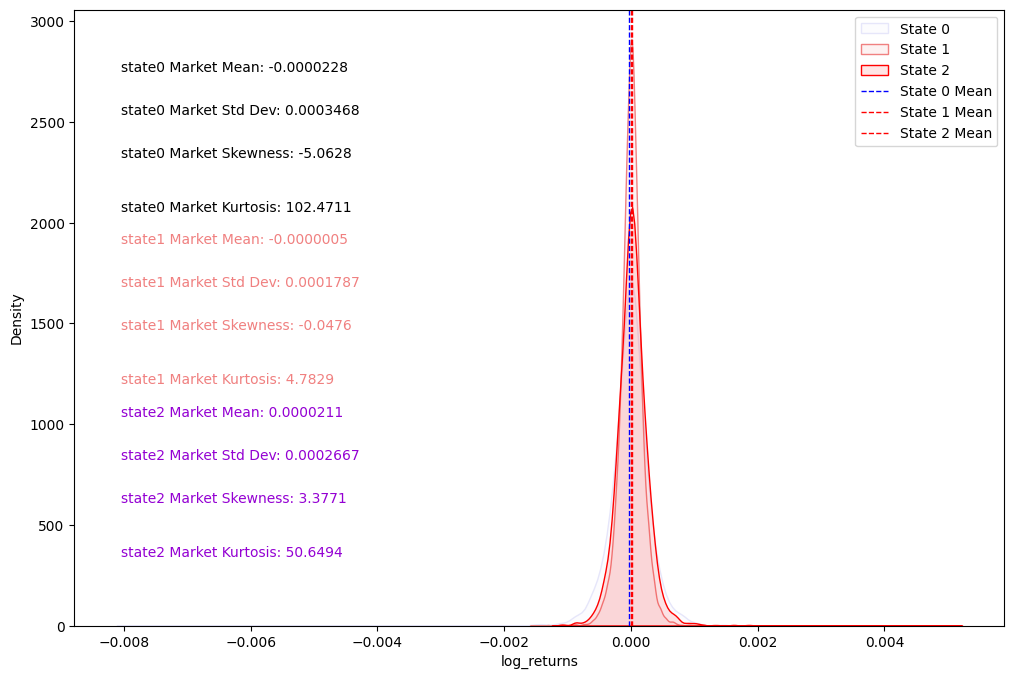

In [522]:
state0 = df_org[df_org['state'] == 0 ]
state1 = df_org[df_org['state'] == 1 ]
state2 = df_org[df_org['state'] == 2 ]


#sns.set_theme(style="dark", rc={"axes.grid": False})

# Définir le style de fond de la figure
#plt.style.use('dark_background')


plt.figure(figsize=(12, 8))
sns.kdeplot(state0['log_returns'], color='lavender', label='State 0', fill=True, alpha=0.1)
sns.kdeplot(state1['log_returns'], color='lightcoral', label='State 1', fill=True, alpha=0.1)
sns.kdeplot(state2['log_returns'], color='red', label='State 2', fill=True, alpha=0.1)
plt.axvline( state0['log_returns'].mean(), color='blue', linestyle='dashed', linewidth=1, label='State 0 Mean')
plt.axvline( state1['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 1 Mean')
plt.axvline( state2['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 2 Mean')
plt.legend()
#state0.head()
#state1.head()

y_cord = 0.90
delt = 0.07 # Ajustez si nécessaire pour mieux adapter les annotations au graphique
for market, color, label in [(state0, 'black', 'state0'), (state1, 'lightcoral', 'state1'), (state2, 'darkviolet', 'state2')]:
    # Calcul des statistiques
    mean = market['log_returns'].mean()
    std_dev = market['log_returns'].std()
    skewness = skew(market['log_returns'])
    kurt = kurtosis(market['log_returns'])

    # Annotations pour la moyenne et l'écart type
    plt.annotate(f'{label} Market Mean: {mean:.7f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Std Dev: {std_dev:.7f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    
    # Annotations pour le skewness et le kurtosis
    plt.annotate(f'{label} Market Skewness: {skewness:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Kurtosis: {kurt:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color, verticalalignment='top')
    y_cord -= delt  # Espacement additionnel avant de passer au prochain marché


print(state0['log_returns'].mean())
print(state1['log_returns'].mean())
print(state2['log_returns'].mean())

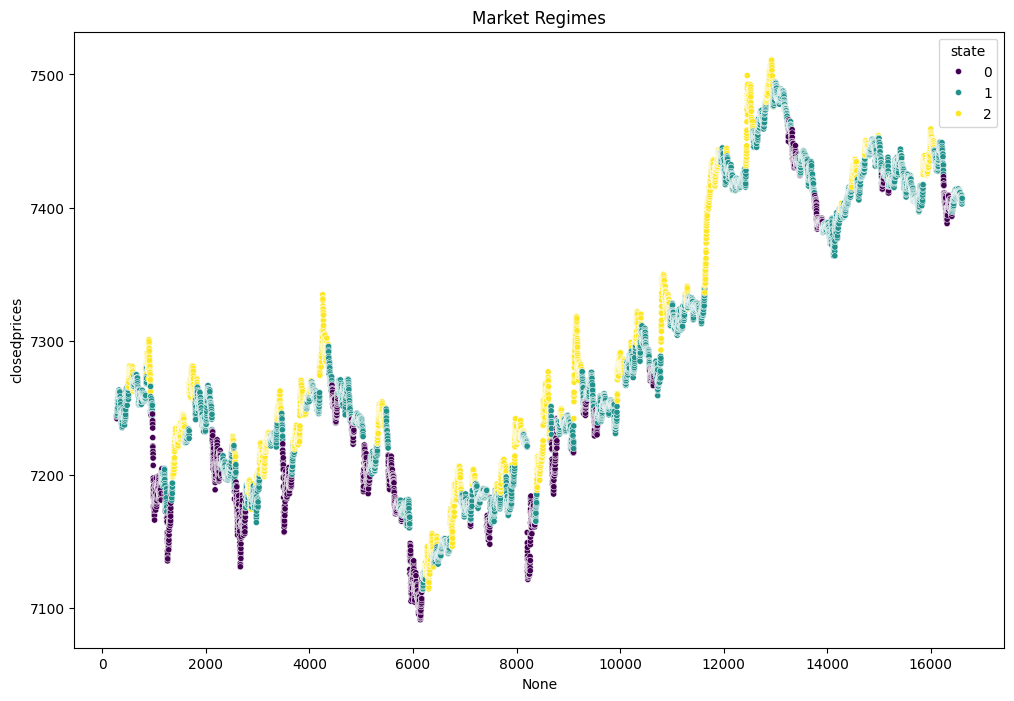

In [523]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_org.index, y='closedprices', hue='state', data=df_org, s=20, palette='viridis')
plt.title('Market Regimes')

plt.show()

In [524]:
#MACD_FAST = 12
#MACD_SLOW = 26
#MACD_SIGNAL = 9

#macd,macdSignal, macdHist  = MACD(graph.olhc4, fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)

#graph.loc[:, 'macd'] = macd
#graph.loc[:, 'macdSignal'] = macdSignal
#graph.loc[:, 'macdHist'] = macdHist

#graph.head()

#fig = go.Figure(data=[go.Scatter(x=graph['SnapshotTime'], y=graph['macdHist'],  mode='lines+markers', marker = mark)])

#layout = go.Layout(template='plotly_dark',
#                   title ='macd' , height=500,
#                    xaxis_rangeslider_visible=True)
#fig.update_layout(layout)
#fig.show()

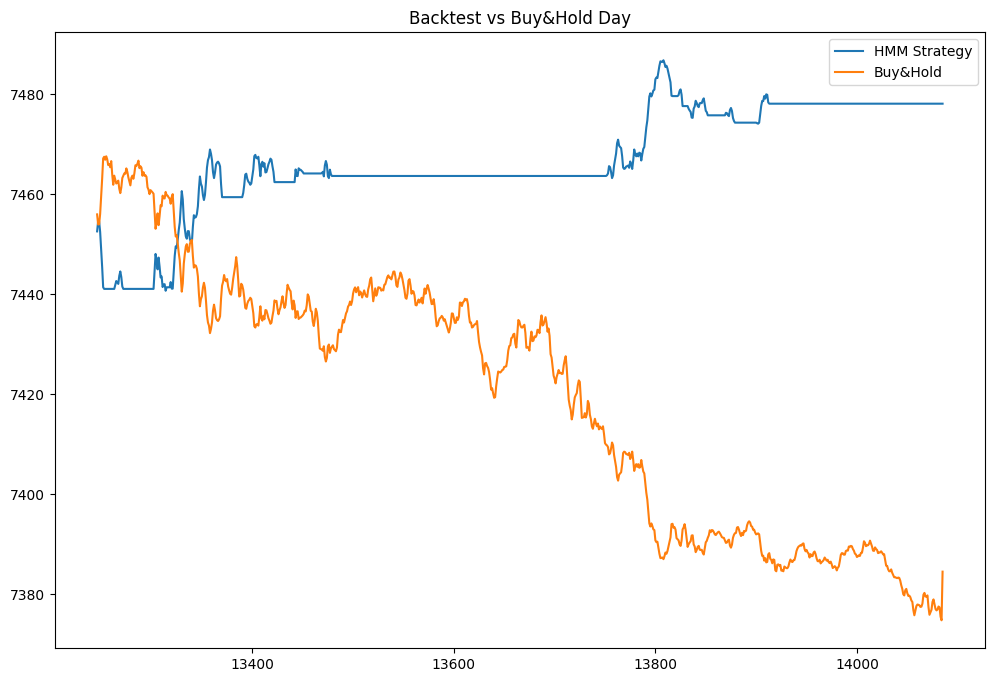

In [525]:
plt.figure(figsize=(12, 8))
plt.title(f'Backtest vs Buy&Hold Day')
plt.plot(np.exp(df_day['backtest'].mul(1)).cumprod().mul(df_day['closedprices'].iloc[0]), label='HMM Strategy')
plt.plot(np.exp(df_day['forward_returns'].mul(1)).cumprod().mul(df_day['closedprices'].iloc[0]), label='Buy&Hold')
plt.legend()
#plt.savefig('backtest_vs_B&H.png', dpi=300)
plt.show()

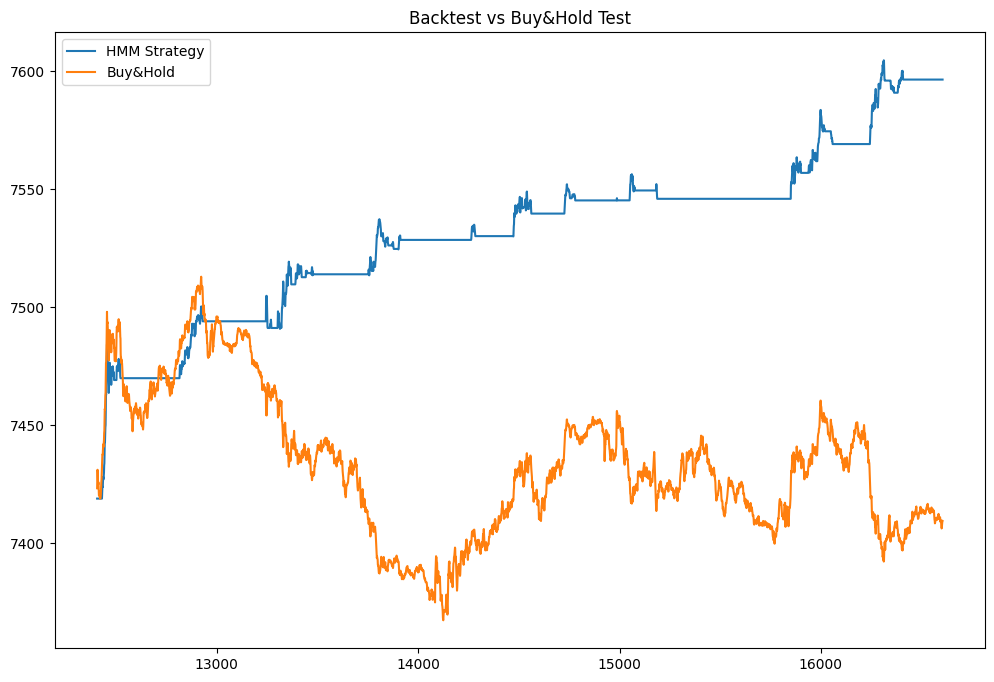

In [526]:
plt.figure(figsize=(12, 8))
plt.title('Backtest vs Buy&Hold Test')
plt.plot(np.exp(df_test['backtest'].mul(1)).cumprod().mul(df_test['closedprices'].iloc[0]), label='HMM Strategy')
plt.plot(np.exp(df_test['forward_returns'].mul(1)).cumprod().mul(df_test['closedprices'].iloc[0]), label='Buy&Hold')
plt.legend()
#plt.savefig('backtest_vs_B&H.png', dpi=300)
plt.show()

In [527]:
def calculer_metrics_portefeuille(resampled_returns, capital, operation, spread):
    # Calcul des paramètres annuels
    sigma = resampled_returns.std() * np.sqrt(356)
    mu = resampled_returns.mean() * 356

    # Ratio de Sharpe
    sharpe = mu / sigma

    # Evolution du portefeuille
    pf = capital * np.exp(resampled_returns).cumprod()

    # Drawdown maximal
    max_dd = -min(pf / pf.expanding(1).max() - 1)

    # Ratio de Calmar
    calmar = mu / max_dd

    # Volatilité des rendements négatifs
    sigma_neg = np.sqrt(np.mean(resampled_returns[resampled_returns < 0].pow(2))) * np.sqrt(356)

    # Ratio de Sortino
    sortino = mu / sigma_neg

    # Ajustement de la distribution des rendements avec Johnson SU
    a, b, loc, scale = johnsonsu.fit(resampled_returns)

    # Value at Risk au niveau de confiance de 99% pour 1 jour
    alpha_risk = 0.99
    VAR_99_1j = johnsonsu.ppf(1 - alpha_risk, a, b, loc, scale) * capital * -1

    # Approximation de la VaR pour 10 jours
    approx_VAR_99_10j = VAR_99_1j * np.sqrt(10)

    # Structurer les résultats dans un dictionnaire
    resultats = {
        'start' : capital,
        'gain point': pf.iloc[-1] - capital,
        'gain point net': pf.iloc[-1] - capital - (operation * spread),
        'operation' : operation,
        'Sharpe Ratio': sharpe,
        'Capital Final': pf.iloc[-1],
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Sortino Ratio': sortino,
        'VaR 99% 1 Jour': VAR_99_1j,
        'VaR 99% 10 Jours': approx_VAR_99_10j
    }

    # Formater et retourner les résultats
    return {k: f"{v:.2f}" for k, v in resultats.items()}

calculer_metrics_portefeuille(df_org['backtest'], df_org['closedprices'].iloc[0], df_org['operation'].sum(), 0.5)


#print( df_org['operation'].sum())

{'start': '7243.90',
 'gain point': '1119.55',
 'gain point net': '903.55',
 'operation': '432.00',
 'Sharpe Ratio': '1.15',
 'Capital Final': '8363.45',
 'Max Drawdown': '0.00',
 'Calmar Ratio': '0.68',
 'Sortino Ratio': '0.67',
 'VaR 99% 1 Jour': '0.00',
 'VaR 99% 10 Jours': '0.00'}

In [528]:
calculer_metrics_portefeuille(df_test['backtest'], df_test['closedprices'].iloc[0],  df_test['operation'].sum(), 0.5)

{'start': '7419.00',
 'gain point': '177.47',
 'gain point net': '139.47',
 'operation': '76.00',
 'Sharpe Ratio': '1.11',
 'Capital Final': '7596.47',
 'Max Drawdown': '0.00',
 'Calmar Ratio': '0.73',
 'Sortino Ratio': '0.57',
 'VaR 99% 1 Jour': '0.00',
 'VaR 99% 10 Jours': '0.00'}

In [529]:
df_test.head()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,low,olhc4_filter,olhc4_filter2,state,position,signal,shifted_signal,fee,backtest,operation
12406,"{'Ask': 7420.0, 'Bid': 7418.0, 'LastTraded': N...","{'Ask': 7420.2, 'Bid': 7418.2, 'LastTraded': N...",154,"{'Ask': 7414.4, 'Bid': 7410.4, 'LastTraded': N...","{'Ask': 7416.8, 'Bid': 7413.8, 'LastTraded': N...",2024-12-09 08:00:00,2024-12-09T07:00:00,7415.3,7419.2,7412.4,...,7421.597246,7424.974684,7424.949568,1,0,0,0.0,0,0.0,0
12407,"{'Ask': 7423.0, 'Bid': 7421.0, 'LastTraded': N...","{'Ask': 7425.0, 'Bid': 7423.0, 'LastTraded': N...",105,"{'Ask': 7419.7, 'Bid': 7417.7, 'LastTraded': N...","{'Ask': 7419.7, 'Bid': 7417.7, 'LastTraded': N...",2024-12-09 08:01:00,2024-12-09T07:01:00,7418.7,7424.0,7418.7,...,7421.334241,7424.691717,7424.152724,1,0,0,0.0,0,0.0,0
12408,"{'Ask': 7430.2, 'Bid': 7428.2, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",72,"{'Ask': 7423.5, 'Bid': 7421.5, 'LastTraded': N...","{'Ask': 7423.5, 'Bid': 7421.5, 'LastTraded': N...",2024-12-09 08:02:00,2024-12-09T07:02:00,7422.5,7430.0,7422.5,...,7421.286340,7425.120567,7425.516277,1,1,0,0.0,0,0.0,0
12409,"{'Ask': 7428.5, 'Bid': 7426.5, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",28,"{'Ask': 7428.2, 'Bid': 7426.2, 'LastTraded': N...","{'Ask': 7431.0, 'Bid': 7429.0, 'LastTraded': N...",2024-12-09 08:03:00,2024-12-09T07:03:00,7430.0,7430.0,7427.2,...,7421.416172,7425.346910,7426.052192,1,1,0,0.0,0,-0.0,0
12410,"{'Ask': 7428.2, 'Bid': 7426.2, 'LastTraded': N...","{'Ask': 7429.5, 'Bid': 7427.5, 'LastTraded': N...",35,"{'Ask': 7427.7, 'Bid': 7425.7, 'LastTraded': N...","{'Ask': 7428.7, 'Bid': 7426.7, 'LastTraded': N...",2024-12-09 08:04:00,2024-12-09T07:04:00,7427.7,7428.5,7426.7,...,7421.572841,7425.523185,7426.362279,1,1,0,0.0,0,-0.0,0


In [530]:
df_test.tail()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,...,low,olhc4_filter,olhc4_filter2,state,position,signal,shifted_signal,fee,backtest,operation
16600,"{'Ask': 7403.9, 'Bid': 7401.9, 'LastTraded': N...","{'Ask': 7406.1, 'Bid': 7404.1, 'LastTraded': N...",35,"{'Ask': 7403.9, 'Bid': 7401.9, 'LastTraded': N...","{'Ask': 7405.4, 'Bid': 7403.4, 'LastTraded': N...",2024-12-13 21:54:00,2024-12-13T20:54:00,7404.4,7405.1,7402.9,...,7404.922490,7406.886216,7405.162289,1,0,0,0.0,0,0.0,0
16601,"{'Ask': 7405.4, 'Bid': 7403.4, 'LastTraded': N...","{'Ask': 7405.4, 'Bid': 7403.4, 'LastTraded': N...",18,"{'Ask': 7404.6, 'Bid': 7402.6, 'LastTraded': N...","{'Ask': 7404.6, 'Bid': 7402.6, 'LastTraded': N...",2024-12-13 21:55:00,2024-12-13T20:55:00,7403.6,7404.4,7403.6,...,7404.566243,7406.649715,7404.956352,1,0,0,0.0,0,0.0,0
16602,"{'Ask': 7406.4, 'Bid': 7404.4, 'LastTraded': N...","{'Ask': 7406.9, 'Bid': 7404.9, 'LastTraded': N...",20,"{'Ask': 7405.9, 'Bid': 7403.9, 'LastTraded': N...","{'Ask': 7405.9, 'Bid': 7403.9, 'LastTraded': N...",2024-12-13 21:56:00,2024-12-13T20:56:00,7404.9,7405.9,7404.9,...,7404.417284,7406.530836,7405.076206,1,0,0,0.0,0,0.0,0
16603,"{'Ask': 7407.6, 'Bid': 7405.6, 'LastTraded': N...","{'Ask': 7407.6, 'Bid': 7405.6, 'LastTraded': N...",20,"{'Ask': 7406.4, 'Bid': 7404.4, 'LastTraded': N...","{'Ask': 7406.6, 'Bid': 7404.6, 'LastTraded': N...",2024-12-13 21:57:00,2024-12-13T20:57:00,7405.6,7406.6,7405.4,...,7404.355684,7406.537415,7405.487869,1,0,0,0.0,0,0.0,0
16604,"{'Ask': 7408.1, 'Bid': 7406.1, 'LastTraded': N...","{'Ask': 7408.1, 'Bid': 7406.1, 'LastTraded': N...",2,"{'Ask': 7407.4, 'Bid': 7405.4, 'LastTraded': N...","{'Ask': 7407.9, 'Bid': 7405.9, 'LastTraded': N...",2024-12-13 21:58:00,2024-12-13T20:58:00,7406.9,7407.1,7406.4,...,7404.332510,7406.590931,7405.923396,1,0,0,0.0,0,0.0,0
